<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 

__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis,Visualization,Storage and Vectorizations</h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from fuzzywuzzy import fuzz
import datetime as dt
from nltk.corpus import stopwords
import os
from os import path
from sklearn.manifold import TSNE
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics.classification import accuracy_score, log_loss
import gc
import sqlite3
import pickle
import tqdm
from sqlalchemy import create_engine
import re
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from collections import Counter
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

C:\Users\sundararaman\Anaconda2\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



<h2> 3.1 Reading data and basic stats </h2>

In [2]:
#Derive the id from the google drive shareable link.
# resource  : https://stackoverflow.com/questions/19611729/getting-google-spreadsheet-csv-into-a-pandas-dataframe
file_id='10QDGTSI5PEV9e7CTpfzsXRpUwRIsJA-J'
link='https://drive.google.com/uc?export=download&id={FILE_ID}'
csv_url=link.format(FILE_ID=file_id)
#The final url would be as below:-
#csv_url='https://drive.google.com/uc?export=download&id=1-tjNjMP6w0RUV4GhJWw08ql3wYwsNU69'
df = pd.read_csv(csv_url)

In [3]:
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h2> 3.2 Basic Analyis </h2>

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) question

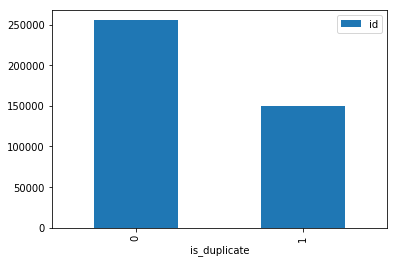

In [5]:
df.groupby("is_duplicate")['id'].count().plot.bar().legend()

In [6]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [7]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [8]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



Text(0.5, 1.0, 'number of unique questions and repeated questions')

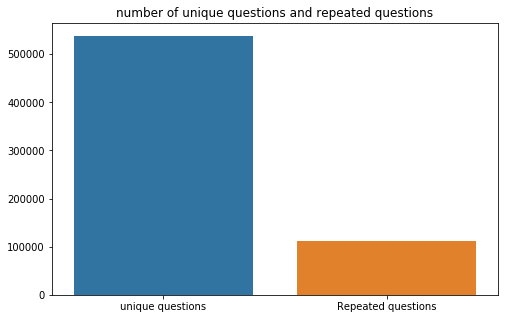

In [9]:
### plot number of unique questions and repeated questions
x = ['unique questions','Repeated questions']
y=[unique_qs,qs_morethan_onetime]
plt.figure(figsize=(8,5))
sns.barplot(x,y)
plt.title('number of unique questions and repeated questions')


<h3> 3.2.4 Check for duplicates </h3>

In [10]:
### check of the question pairs are repeated
dup=len(df[df.duplicated(subset=['qid1','qid2'])==True])
print('Number of duplicate rows are: ',dup)

Number of duplicate rows are:  0


<h3> 3.2.5 Frequency of questions occuring in dataset</h3>

Maximum number of times a single question is repeated: 157



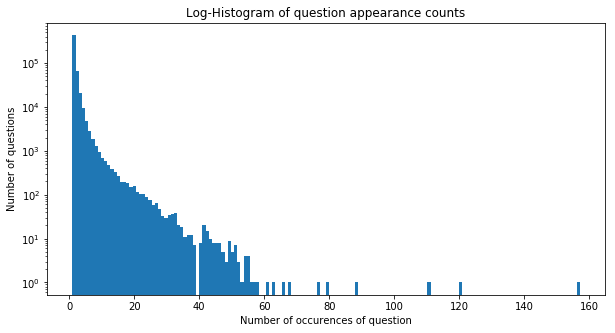

In [11]:
plt.figure(figsize=(10,5))
plt.hist(qids.value_counts(),bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.6 Check for null values</h3>

In [12]:
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [13]:
# replace null values with ''
df=df.fillna('')
print('Number of nan values : ',df[df.isnull().any(1)])

Number of nan values :  Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2> 3.3  EDA : Generating basic features </h2>

#####  Number of basic features 
     1. frequency of question 1
     2. frequency of question 2
     3. length of q1
     4. length of q2
     5. number of words in q1
     6. number of words in q2
     7. words common in q1 q2 
     8. total words ain q1 and q2
     9. word_Share=wod_common/total_words
    10. freq of q1 + freq of q2 
    11. freq of q1 - freq of q2 

In [14]:
# frequency of q1
df['freq_q1'] = df.groupby('qid1')['qid1'].transform('count')
# frequency of q2
df['freq_q2'] = df.groupby('qid2')['qid2'].transform('count')
# Length of q1 
df['len_q1'] =  df['question1'].apply(lambda x : len(x.strip()))
# Length of q2 
df['len_q2'] =  df['question2'].apply(lambda x : len(x.strip()))
# number of common words in q1 and q2
def common_words(row):
    w1 = set(map(lambda x : x.lower().strip() ,row['question1'].split(' ')))
    w2 = set(map(lambda x : x.lower().strip() ,row['question2'].split(' ')))
    return len(w1.intersection(w2))
df['common_words'] = df.apply(common_words,axis=1)
    
# total words in q1 and q2
def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1) + len(w2)
df['total_words'] = df.apply(normalized_word_Total, axis=1)

# word_share in q1 and q2
df['word_share'] = df['common_words'] / df['total_words']

# freq q1 + freq q2
df['freq_q1+q2'] = df['freq_q1'] + df['freq_q2']

# freq q1 - freq q2
df['freq_q1-q2'] = abs(df['freq_q1'] - df['freq_q2'])

# number of words in q1 and q2

df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

In [15]:
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,len_q1,len_q2,common_words,total_words,word_share,freq_q1+q2,freq_q1-q2,q1_n_words,q2_n_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,10,23,0.434783,2,0,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,4,20,0.200000,5,3,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,4,24,0.166667,2,0,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,0,19,0.000000,2,0,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,2,20,0.100000,4,2,13,7


### 3.3.1 Univariate analysis on Basic features 

In [16]:
print('Number of questions that occured only once in question 1',len(df[df['freq_q1'] == 1]))
print('Number of questions that occured only once in question 2' , len(df[df['freq_q2'] == 1]))
print('Number of questions in question 1 having only one word : ',len(df[df['q1_n_words'] == 1]))
print('Number of questions in question 2 having only one word: ',len(df[df['q2_n_words'] == 1]))

Number of questions that occured only once in question 1 236581
Number of questions that occured only once in question 2 253733
Number of questions in question 1 having only one word :  67
Number of questions in question 2 having only one word:  24


##### 3.3.1.1 feature : Word Share 

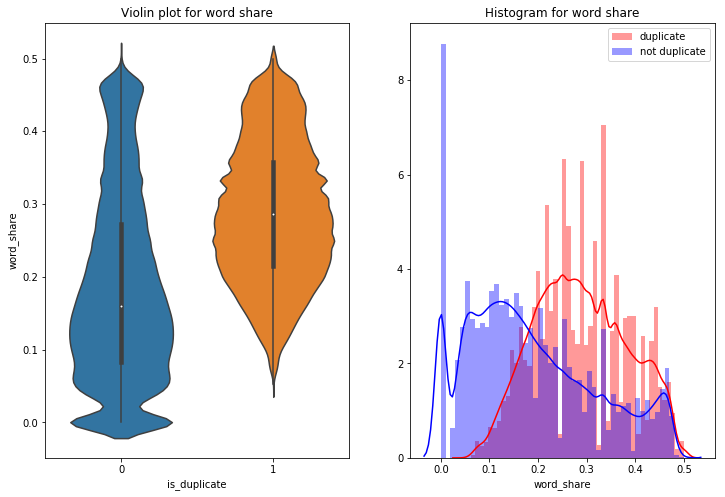

In [17]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot('is_duplicate','word_share',data=df)
plt.title('Violin plot for word share')
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1]['word_share'],label='duplicate',color='r')
sns.distplot(df[df['is_duplicate']==0]['word_share'],label='not duplicate',color='b')
plt.title('Histogram for word share')
plt.legend()

#####  3.3.1.2 Feature: word_Common 

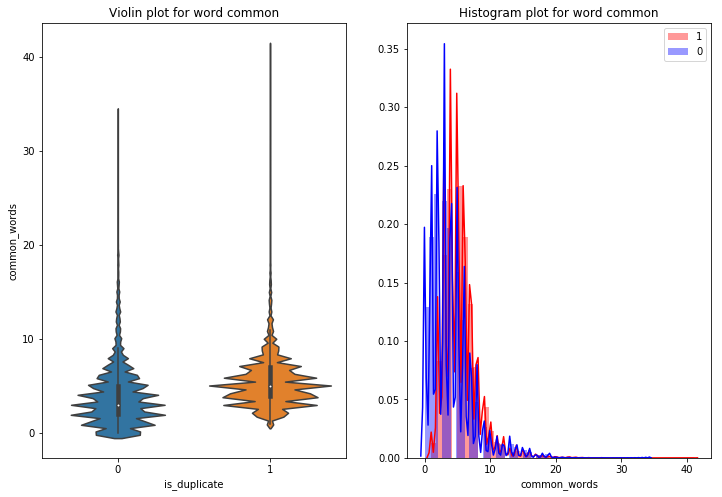

In [81]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'common_words', data = df[0:])
plt.title('Violin plot for word common')
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['common_words'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['common_words'][0:] , label = "0" , color = 'blue' )
plt.title('Histogram plot for word common')
plt.legend()
plt.show()

### 3.4 Preprocessing of Text
        - Preprocessing:
        - Removing html tags 
        - Removing Punctuations
        - Performing stemming
        - Removing Stopwords
        - Expanding contractions etc.

In [19]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 
STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [20]:
## creating adavanced features 
## defining tokens,words and stop words
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
def advanced_features(q1,q2):
    tws_features=[0]*10
    sent_q1 = q1.split()
    sent_q2 = q2.split()
    # if there is any empty cells
    if len(sent_q1) == 0 or len(sent_q2) == 0:
        return tws_features
    # tokens   
    tokens_q1 = set([i for i in sent_q1])
    tokens_q2 = set([i for i in sent_q2])
    # words
    words_q1 = set([i for i in sent_q1 if i not in STOP_WORDS])
    words_q2 = set([i for i in sent_q2 if i not in STOP_WORDS])
    # stopwords
    stopwords_q1 = set([i for i in sent_q1 if i in STOP_WORDS])
    stopwords_q2 = set([i for i in sent_q2 if i in STOP_WORDS])
    # common_tokens
    common_tokens = len(tokens_q1.intersection(tokens_q2))
    # common_stopwords
    common_stopwords = len(stopwords_q1.intersection(stopwords_q2))
    # common_words
    common_words = len(words_q1.intersection(words_q2))
    # cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
    tws_features[0] = common_words / (min(len(words_q1),len(words_q2)) + SAFE_DIV)
    # cwc_max 
    tws_features[1] = common_words / (max(len(words_q1),len(words_q2)) + SAFE_DIV)
    # csc_min 
    tws_features[2] = common_stopwords / (min(len(stopwords_q1),len(stopwords_q2)) + SAFE_DIV)
    # csc_max 
    tws_features[3] = common_stopwords / (max(len(stopwords_q1),len(stopwords_q2)) + SAFE_DIV)
    # ctc_min 
    tws_features[4] = common_tokens / (min(len(tokens_q1),len(tokens_q2)) + SAFE_DIV)
    # ctc_max 
    tws_features[5] = common_tokens / (max(len(tokens_q1),len(tokens_q2)) + SAFE_DIV) 
    # first word equal
    tws_features[6] = int(sent_q1[0] == sent_q2[0])
    # last word equal
    tws_features[7] = int(sent_q1[-1] == sent_q2[-1])
    # abs_len_diff
    tws_features[8] = abs(len(sent_q1) - len(sent_q2))
    # mean len
    tws_features[9] = (len(sent_q1) + len(sent_q2))/2
    return tws_features

#def extract_features(df):
## first preprocess the data 
df['question1'] = df['question1'].fillna('').apply(preprocess)
df['question2'] = df['question2'].fillna('').apply(preprocess)

# token features
token_features = df.apply(lambda x: advanced_features(x["question1"], x["question2"]), axis=1)

# creating new features
df['cwc_min'] = list(map(lambda x: x[0],token_features))
df['cwc_max'] = list(map(lambda x: x[1],token_features))
df['csc_min'] = list(map(lambda x: x[2],token_features))
df['csc_max'] = list(map(lambda x: x[3],token_features))
df['ctc_min'] = list(map(lambda x: x[4],token_features))
df['ctc_max'] = list(map(lambda x: x[5],token_features))
df['first_word_eq'] = list(map(lambda x: x[6],token_features))
df['last_word_eq'] = list(map(lambda x: x[7],token_features))
df['abs_len_diff'] = list(map(lambda x: x[8],token_features))
df['mean_len'] = list(map(lambda x: x[9],token_features))

# fuzzy features
df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
# The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
# then joining them back into a string We then compare the transformed strings with a simple ratio().
df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)

<h3> 3.5.1 Adding a new advanced feature :  similarity of nouns </h3> 
    * lib reference:http://www.nltk.org/book_1ed/ch05.html,https://stackoverflow.com/questions/17669952/finding-proper-nouns-using-nltk-wordnet

In [21]:
'''Common nouns finds similarity of nouns between sentences.'''
from nltk.tag import pos_tag
def noun_share(q1,q2) :
    'function returns  common nouns / total nouns'
    tag_s1 = pos_tag(q1)
    tag_s2 = pos_tag(q2)
    ## NNP refers to proper noun , NNS :singular noun and NN:plural nouns
    pnouns_s1 = set([word for word,pos in tag_s1 if pos in ['NNP','NN','NNS']])
    pnouns_s2 = set([word for word,pos in tag_s2 if pos in ['NNP','NN','NNS']])
    total_nouns = pnouns_s1.union(pnouns_s2)
    common_nouns = pnouns_s1.intersection(pnouns_s2)
    return len(common_nouns)/len(total_nouns) * 100

##### Examples

In [22]:
## lets check how good we are able to detect the sentences as similar based on nouns
# consider two almost similar looking sentences that are differnt due to the noun 'India'
s1='How to get a job?'
s2='How to get a job in India?'
print('result from fuzz.QRatio is :',fuzz.QRatio(s1,s2))
print('result from fuzz.partial_ratio is :',fuzz.partial_ratio(s1,s2))
print('result from fuzz.token_set_ratio is :',fuzz.token_set_ratio(s1,s2))
print('result from fuzz.token_sort_ratio is :',fuzz.token_sort_ratio(s1,s2))
print('result from noun_share is :',noun_share(s1,s2))

result from fuzz.QRatio is : 78
result from fuzz.partial_ratio is : 94
result from fuzz.token_set_ratio is : 100
result from fuzz.token_sort_ratio is : 78
result from noun_share is : 77.77777777777779


In [23]:
# these are two similar questions.noun share performs better than QQratio
s1='I\'m from India and I want to get a job here'
s2='How to get a job in India'
print('result from fuzz.QRatio is :',fuzz.QRatio(s1,s2))
print('result from fuzz.partial_ratio is :',fuzz.partial_ratio(s1,s2))
print('result from fuzz.token_set_ratio is :',fuzz.token_set_ratio(s1,s2))
print('result from fuzz.token_sort_ratio is :',fuzz.token_sort_ratio(s1,s2))
print('result from noun_share is :',noun_share(s1,s2))

result from fuzz.QRatio is : 47
result from fuzz.partial_ratio is : 61
result from fuzz.token_set_ratio is : 84
result from fuzz.token_sort_ratio is : 65
result from noun_share is : 53.84615384615385


In [24]:
## here there are many common words but are entirely differnt due to a noun
s1 = 'most viewed Sport in the world'
s2 = 'most viewed Movie in the world'
print('result from fuzz.QRatio is :',fuzz.QRatio(s1,s2))
print('result from fuzz.partial_ratio is :',fuzz.partial_ratio(s1,s2))
print('result from fuzz.token_set_ratio is :',fuzz.token_set_ratio(s1,s2))
print('result from fuzz.token_sort_ratio is :',fuzz.token_sort_ratio(s1,s2))
print('result from noun_share is :',noun_share(s1,s2))

result from fuzz.QRatio is : 87
result from fuzz.partial_ratio is : 87
result from fuzz.token_set_ratio is : 89
result from fuzz.token_sort_ratio is : 87
result from noun_share is : 80.0


#### Observations :
       1. We can see that noun share has significant impact on finding disimilar questions.
       2. Most sentences that become very disimilar due to a nouns which can be captured here.

In [25]:
df["noun_share"]  = df.apply(lambda x: noun_share(x["question1"], x["question2"]), axis=1)

In [26]:
len(df)

404290

<h3>3.5.2 Analysis of extracted features </h3>

<h4> 3.5.2.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [27]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p),type(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
# np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
# np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526 <class 'numpy.ndarray'>
Number of data points in class 0 (non duplicate pairs) : 510054


In [28]:
# reading the text files and removing the Stop Words:
from wordcloud import WordCloud, STOPWORDS
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 891339
Total number of words in non duplicate pair questions : 33193130


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


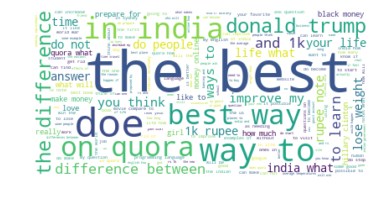

In [29]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


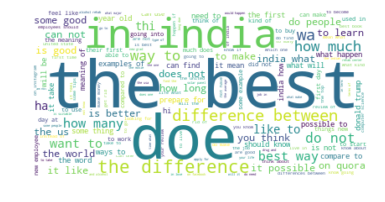

In [30]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.2.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio','noun_share'] </h4>

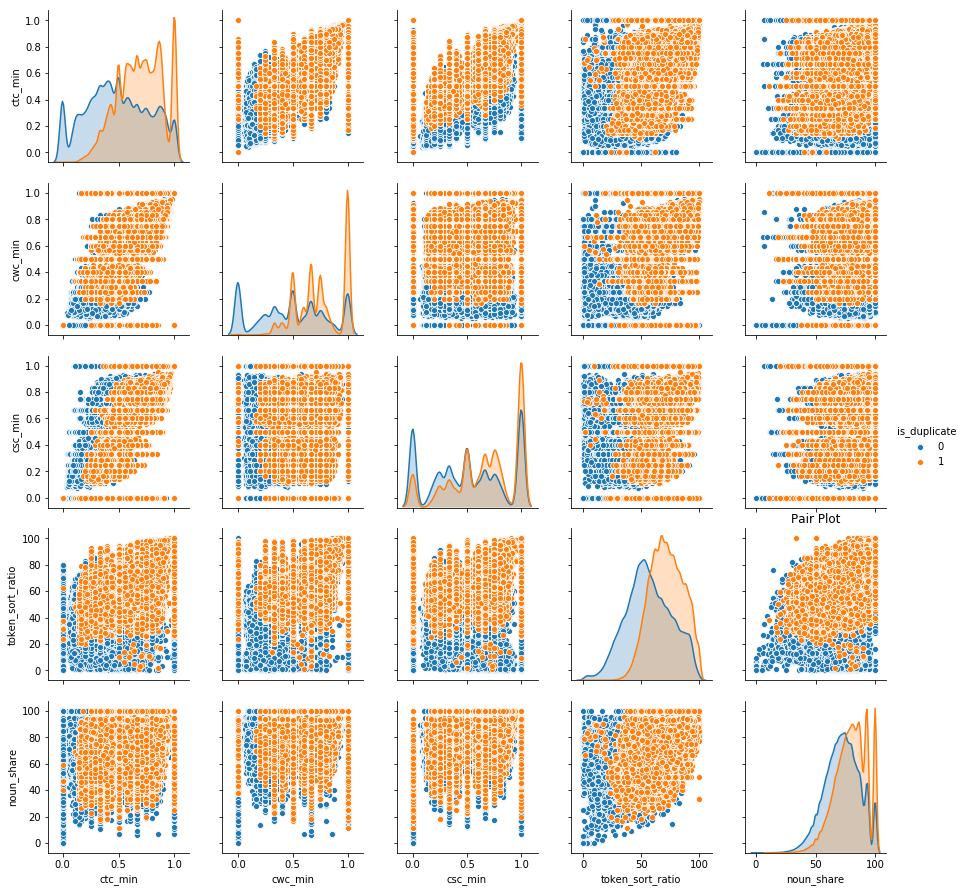

In [82]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio','noun_share' ,'is_duplicate']][0:n],
             hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio','noun_share'])
plt.title('Pair Plot')
plt.show()

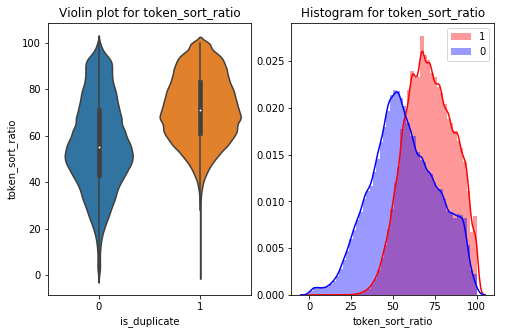

In [83]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(8, 5))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )
plt.title('Violin plot for token_sort_ratio')
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.title('Histogram for token_sort_ratio')
plt.legend()
plt.show()

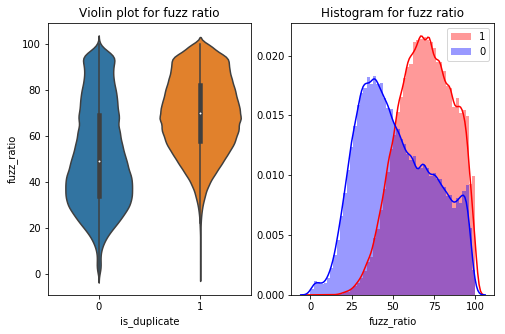

In [84]:
plt.figure(figsize=(8,5))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )
plt.title('Violin plot for fuzz ratio')
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.title('Histogram for fuzz ratio')
plt.legend()
plt.show()

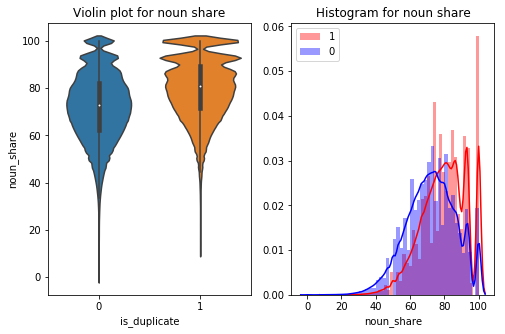

In [85]:
plt.figure(figsize=(8,5))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'noun_share', data = df[0:] , )
plt.title('Violin plot for noun share')
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['noun_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['noun_share'][0:] , label = "0" , color = 'blue' )
plt.title('Histogram for noun share')
plt.legend()
plt.show()

<h3>3.6 Visualization using TSNE in 2D and 3D</h3>

In [35]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['freq_q1',
       'freq_q2', 'len_q1', 'len_q2', 'common_words', 'total_words',
       'word_share', 'freq_q1+q2', 'freq_q1-q2', 'q1_n_words', 'q2_n_words',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'first_word_eq', 'last_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'noun_share']])
y = dfp_subsampled['is_duplicate'].values

C:\Users\sundararaman\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.



In [36]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.011s...
[t-SNE] Computed neighbors for 5000 samples in 0.894s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.163672
[t-SNE] Computed conditional probabilities in 0.243s
[t-SNE] Iteration 50: error = 82.0040817, gradient norm = 0.0501970 (50 iterations in 2.924s)
[t-SNE] Iteration 100: error = 71.4473267, gradient norm = 0.0116940 (50 iterations in 2.155s)
[t-SNE] Iteration 150: error = 69.8822250, gradient norm = 0.0075890 (50 iterations in 1.834s)
[t-SNE] Iteration 200: error = 69.1894760, gradient norm = 0.0042850 (50 iterations in 1.763s)
[t-SNE] Iteration 250: error = 68.7940292, gradient norm = 0.0031063

C:\Users\sundararaman\Anaconda2\lib\site-packages\seaborn\regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



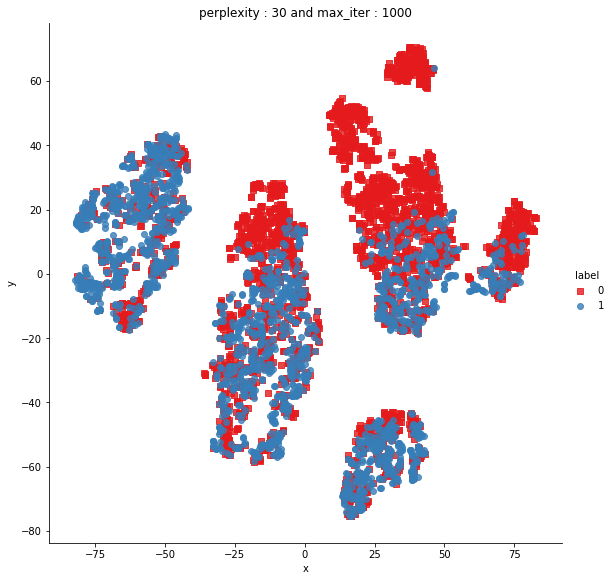

In [37]:
tsne_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=tsne_df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [38]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.014s...
[t-SNE] Computed neighbors for 5000 samples in 0.864s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.163672
[t-SNE] Computed conditional probabilities in 0.213s
[t-SNE] Iteration 50: error = 80.6606598, gradient norm = 0.0329198 (50 iterations in 8.978s)
[t-SNE] Iteration 100: error = 70.3801346, gradient norm = 0.0039543 (50 iterations in 4.951s)
[t-SNE] Iteration 150: error = 69.1435394, gradient norm = 0.0017224 (50 iterations in 3.981s)
[t-SNE] Iteration 200: error = 68.6667099, gradient norm = 0.0011949 (50 iterations in 3.845s)
[t-SNE] Iteration 250: error = 68.3961105, gradient norm = 0.0009459

In [88]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

<h3>3.7 Storing the data into SQL table </h3>

In [40]:
# store the csv file containing all features
df.to_csv('final_features.csv')

In [41]:
pd.read_csv('final_features.csv').columns

Index(['Unnamed: 0', 'id', 'qid1', 'qid2', 'question1', 'question2',
       'is_duplicate', 'freq_q1', 'freq_q2', 'len_q1', 'len_q2',
       'common_words', 'total_words', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'q1_n_words', 'q2_n_words', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'first_word_eq', 'last_word_eq', 'abs_len_diff',
       'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'noun_share'],
      dtype='object')

In [42]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv', names=['Unnamed: 0', 'id', 'qid1', 'qid2', 'question1', 'question2',
       'is_duplicate', 'freq_q1', 'freq_q2', 'len_q1', 'len_q2',
       'common_words', 'total_words', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'q1_n_words', 'q2_n_words', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'first_word_eq', 'last_word_eq', 'abs_len_diff',
       'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'noun_share'], chunksize=chunksize, iterator=True, encoding='utf-8'):
        df.index += index_start                  
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [43]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except:
        print('!!Connection failed!!')
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [44]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [45]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

<h5> 3.7.1 Converting strings to numerics </h5>

In [46]:
## remove unwanted columns
data.drop(columns=['index','id','Unnamed: 0'],inplace=True)

In [47]:
for i in data.columns : 
    if i not in ['question1','question2'] :
        data[i] = data[i].apply(pd.to_numeric)
    else:
        data[i] = data[i].apply(str)

<h3>3.8 Vectorizing using TFIDF on text data </h3>

In [48]:
data.head(2)

,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,len_q1,len_q2,common_words,...,first_word_eq,last_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,noun_share
0,342173,342174,what would it take to have a couple of pints a...,what is a typical day for jimmy wales,0,1,1,73,38,4,...,1,1,8,12.0,65,51,48,57,0.333333,63.157895
1,49074,120426,what are some interesting c projects for a beg...,what are some good intermediate beginner proje...,1,3,2,67,77,6,...,1,0,0,11.0,85,85,69,73,0.205882,93.333333


<h4>3.8.1 Train,Test,Split </h4>

In [49]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data,data['is_duplicate'],stratify=data['is_duplicate'],test_size=0.33)


In [50]:
## drop the y labels from splits
X_train.drop(['is_duplicate'], axis=1, inplace=True)

C:\Users\sundararaman\Anaconda2\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [51]:
X_train.head(2)

,qid1,qid2,question1,question2,freq_q1,freq_q2,len_q1,len_q2,common_words,total_words,...,first_word_eq,last_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,noun_share
27991,346867,346868,has jimmy wales asked any question on quora th...,is there any question on jimmy wales on quora ...,1,1,75,75,8,26,...,0,0,1,14.5,81,77,61,61,0.223684,89.473684
4716,201191,73701,where can i find a website to watch movies wit...,in which sites i can watch hollywood movies fo...,6,6,66,76,7,25,...,0,1,1,12.5,77,69,61,64,0.358209,94.117647


<h4> 3.8.2 Apply TF-IDF Vectorizer on text features </h4>

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create a tfidf vector for question 1
tfidf = TfidfVectorizer(min_df=10,max_features=5000)  
tfidf.fit(X_train['question1'].values)
tfidf_vectorizer_tr_q1 = tfidf.transform(X_train['question1'].values)
tfidf_vectorizer_te_q1 = tfidf.transform(X_test['question1'].values)
print('*'*50)
print('Shape of the train data after tfidf vectorizing for question 1: ' ,tfidf_vectorizer_tr_q1.shape)
print('Shape of the test data after tfidf vectorizing  for question 1: ' ,tfidf_vectorizer_te_q1.shape)
# # create a tfidf vector for question 2
tfidf = TfidfVectorizer(min_df=10,max_features=5000)
tfidf_vectorizer_tr_q2 = tfidf.fit_transform(X_train['question2'].values)
tfidf_vectorizer_te_q2 = tfidf.transform(X_test['question2'].values)
print('Shape of the train data after tfidf vectorizing for question 2: ',tfidf_vectorizer_tr_q2.shape)
print('Shape of the test data after tfidf vectorizing for question 2: ' ,tfidf_vectorizer_te_q2.shape)

**************************************************
Shape of the train data after tfidf vectorizing for question 1:  (67000, 5000)
Shape of the test data after tfidf vectorizing  for question 1:  (33001, 5000)
Shape of the train data after tfidf vectorizing for question 2:  (67000, 5000)
Shape of the test data after tfidf vectorizing for question 2:  (33001, 5000)


<h4>3.8.3 Apply weighted TF-IDFon text features  </h4>

In [53]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
## Glove vectors are global vectors for words which has vector every word in 300d .
## for read more :https://nlp.stanford.edu/projects/glove/
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [54]:
def tfidf_w2v_(data,col):
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(X_train[col].values)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names())
    tfidf_w2v_vectors  = []
    for sentence in data[col]: # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    print('Shape of tfidf w2v vector for ',col,' (',len(tfidf_w2v_vectors),',',len(tfidf_w2v_vectors[0]),')')
    return tfidf_w2v_vectors

tfidf_w2v_vectors_tr_q1 = tfidf_w2v_(X_train,'question1')  
tfidf_w2v_vectors_te_q1 = tfidf_w2v_(X_test,'question1')
tfidf_w2v_vectors_tr_q2 = tfidf_w2v_(X_train,'question2')
tfidf_w2v_vectors_te_q2 = tfidf_w2v_(X_test,'question2')

Shape of tfidf w2v vector for  question1  ( 67000 , 300 )
Shape of tfidf w2v vector for  question1  ( 33001 , 300 )
Shape of tfidf w2v vector for  question2  ( 67000 , 300 )
Shape of tfidf w2v vector for  question2  ( 33001 , 300 )


<h3>3.9 Normalizing numerical features </h3>

In [55]:
## Normalizing using minmaxscalar all numerical variable 
mmscaler =  MinMaxScaler()
subset = ['freq_q1', 'freq_q2','len_q1', 'len_q2', 'common_words', 'total_words', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'q1_n_words', 'q2_n_words', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'first_word_eq','last_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio','longest_substr_ratio', 'noun_share']
X_tra = mmscaler.fit_transform(X_train[subset])
X_tes = mmscaler.transform(X_test[subset])

C:\Users\sundararaman\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.



<h2>4.MODEL BUILDING</h2>

<h3>4.1 Building random model</h3>

In [56]:
from scipy.sparse import hstack
X_tr = hstack((X_tra,tfidf_vectorizer_tr_q1,tfidf_vectorizer_tr_q2)).tocsr()
X_te = hstack((X_tes,tfidf_vectorizer_te_q1,tfidf_vectorizer_te_q2)).tocsr()
print('Number of data points in train data :',X_tr.shape)
print('Number of data points in test data :',X_te.shape)

Number of data points in train data : (67000, 10027)
Number of data points in test data : (33001, 10027)


In [57]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6294029850746269 Class 1:  0.3705970149253731
---------- Distribution of output variable in train data ----------
Class 0:  0.37059483045968306 Class 1:  0.37059483045968306


In [58]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("Gray")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.893793714258
Log loss on Train Data using Random Model 0.887691110831


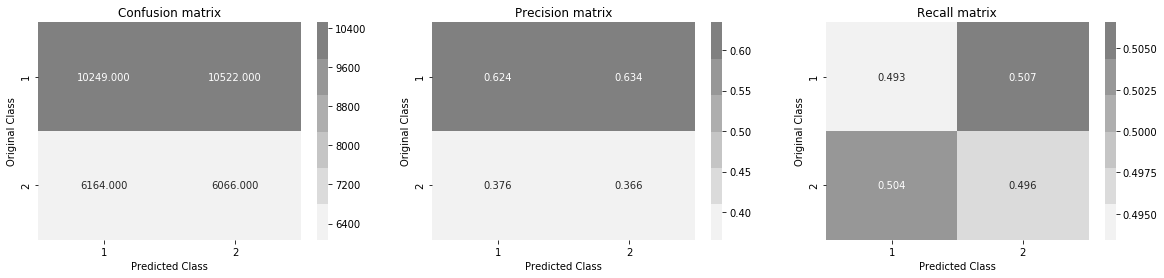

In [59]:
## creating random model 
predicted_y_t = np.zeros((test_len,2))
predicted_y_tr = np.zeros((train_len,2))
for i in range(len(X_test)):
    rand_probs = np.random.rand(1,2)[0]
    predicted_y_t[i] = rand_probs/sum(rand_probs)
for i in range(len(X_train)):
    rand_probs = np.random.rand(1,2)[0]
    predicted_y_tr[i] = rand_probs/sum(rand_probs)
    
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y_t, eps=1e-15))
print("Log loss on Train Data using Random Model",log_loss(y_train, predicted_y_tr, eps=1e-15))
predicted_y =np.argmax(predicted_y_t, axis=1)
plot_confusion_matrix(y_test, predicted_y)   

<h3> 4.2 Logistic Regression with hyperparameter tuning </h3>

Training Logistic model with alpha =  1e-05 log-loss:  0.390233446688
Training Logistic model with alpha =  0.0001 log-loss:  0.399878252542
Training Logistic model with alpha =  0.001 log-loss:  0.447133898658
Training Logistic model with alpha =  0.01 log-loss:  0.512041181625
Training Logistic model with alpha =  0.1 log-loss:  0.54720652861
Training Logistic model with alpha =  1 log-loss:  0.55766455616
Training Logistic model with alpha =  10 log-loss:  0.56462256842


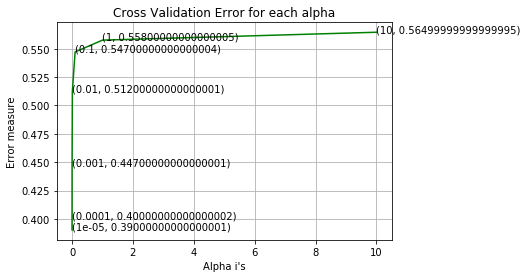

Model trained with best alpha  1e-05 test log-loss is  0.390233446688
Model trained with best alpha  1e-05 train log-loss is  0.332050705079
Total number of data points : 33001


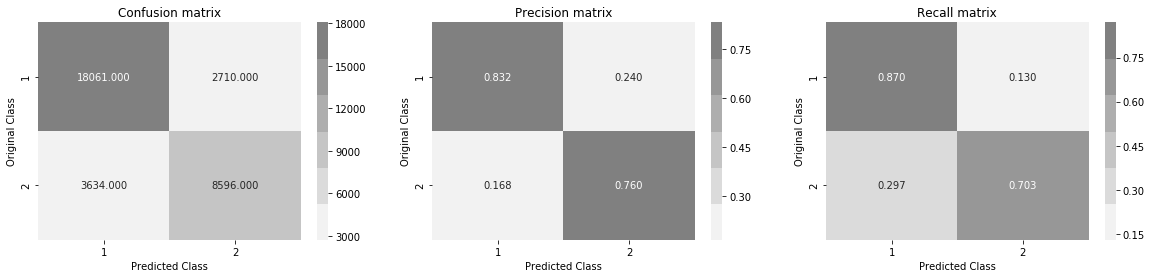

In [60]:
alphas = [10 ** i for i in range(-5,2)]
log_error=[]
for al in alphas:
    LR = SGDClassifier(loss='log',class_weight='balanced',penalty='l2',alpha=al,random_state=4,
                       tol=0.01,max_iter=1000)
    LR.fit(X_tr,y_train)
    clf = CalibratedClassifierCV(LR,method='sigmoid',cv=5)
    clf.fit(X_tr,y_train)
    predict_y = clf.predict_proba(X_te)
    log_error.append(log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))
    print('Training Logistic model with alpha = ',al, 'log-loss: ',log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alphas, log_error,c='g')
for i, txt in enumerate(np.round(log_error,3)):
     ax.annotate((alphas[i],np.round(txt,3)), (alphas[i],log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


#### training model with best hyper parameter 
best_alpha =  np.argmin(log_error)
LR = SGDClassifier(loss='log',class_weight='balanced',penalty='l2',alpha=alphas[best_alpha],random_state=4,
                       tol=0.01,max_iter=1000)
LR.fit(X_tr,y_train)
clf = CalibratedClassifierCV(LR,method='sigmoid',cv=5)
clf.fit(X_tr,y_train)
predict_y = clf.predict_proba(X_te)
predict_y_tr = clf.predict_proba(X_tr)
print('Model trained with best alpha ',alphas[best_alpha],'test log-loss is ',log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))
print('Model trained with best alpha ',alphas[best_alpha],'train log-loss is ',log_loss(y_train,predict_y_tr,labels=clf.classes_,eps=1e-15))

print("Total number of data points :", len(predicted_y))
predicted_y =np.argmax(predict_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h3> 4.3 Linear SVM with hyperparameter tuning </h3>

Training Logistic model with alpha =  1e-05 log-loss:  0.39661097974
Training Logistic model with alpha =  0.0001 log-loss:  0.389531174452
Training Logistic model with alpha =  0.001 log-loss:  0.456684513313
Training Logistic model with alpha =  0.01 log-loss:  0.528237309418
Training Logistic model with alpha =  0.1 log-loss:  0.613094987492
Training Logistic model with alpha =  1 log-loss:  0.659271500681
Training Logistic model with alpha =  10 log-loss:  0.659271500681


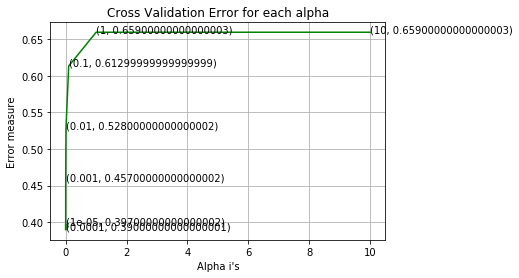

Model trained with best alpha  0.0001 test log-loss is  0.399878252542
Model trained with best alpha  0.0001 train log-loss is  0.374886316211
Total number of data points : 33001


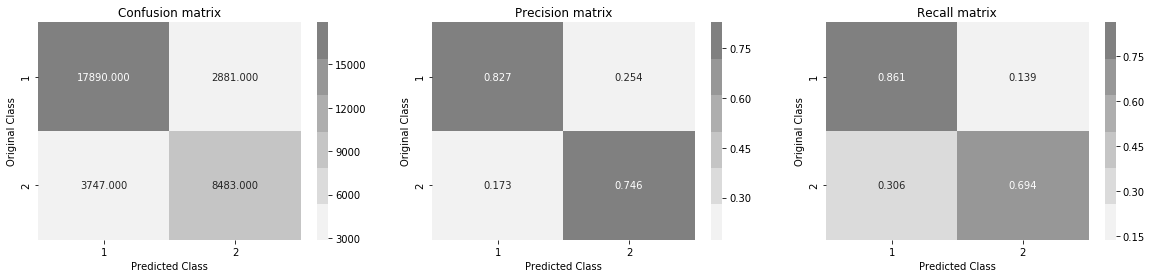

In [61]:
alphas = [10 ** i for i in range(-5,2)]
log_error=[]
for al in alphas:
    SVM = SGDClassifier(loss='hinge',class_weight='balanced',penalty='l1',alpha=al,random_state=4,
                       tol=0.01,max_iter=1000)
    SVM.fit(X_tr,y_train)
    clf = CalibratedClassifierCV(SVM,method='sigmoid',cv=5)
    clf.fit(X_tr,y_train)
    predict_y = clf.predict_proba(X_te)
    log_error.append(log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))
    print('Training Logistic model with alpha = ',al, 'log-loss: ',log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alphas, log_error,c='g')
for i, txt in enumerate(np.round(log_error,3)):
     ax.annotate((alphas[i],np.round(txt,3)), (alphas[i],log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


#### training model with best hyper parameter 
best_alpha =  np.argmin(log_error)
SVM = SGDClassifier(loss='log',class_weight='balanced',penalty='l2',alpha=alphas[best_alpha],random_state=4,
                       tol=0.01,max_iter=1000)
SVM.fit(X_tr,y_train)
clf = CalibratedClassifierCV(SVM,method='sigmoid',cv=5)
clf.fit(X_tr,y_train)
predict_y = clf.predict_proba(X_te)
predict_y_tr = clf.predict_proba(X_tr)
print('Model trained with best alpha ',alphas[best_alpha],'test log-loss is ',log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))
print('Model trained with best alpha ',alphas[best_alpha],'train log-loss is ',log_loss(y_train,predict_y_tr,labels=clf.classes_,eps=1e-15))

print("Total number of data points :", len(predicted_y))
predicted_y =np.argmax(predict_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h3> 4.4 XGBoost with hyperparameter tuning </h3>

In [62]:
import scipy.sparse
tfidf_w2v_vectors_tr_q1 = scipy.sparse.csr_matrix(tfidf_w2v_vectors_tr_q1)
tfidf_w2v_vectors_tr_q2 = scipy.sparse.csr_matrix(tfidf_w2v_vectors_tr_q2)
tfidf_w2v_vectors_te_q1 = scipy.sparse.csr_matrix(tfidf_w2v_vectors_te_q1)
tfidf_w2v_vectors_te_q2 = scipy.sparse.csr_matrix(tfidf_w2v_vectors_te_q2)

In [63]:
from scipy.sparse import hstack
X_tr = hstack((X_tra,tfidf_w2v_vectors_tr_q1,tfidf_w2v_vectors_tr_q2)).tocsr()
X_te = hstack((X_tes,tfidf_w2v_vectors_te_q1,tfidf_w2v_vectors_te_q2)).tocsr()
print('Number of data points in train data :',X_tr.shape)
print('Number of data points in test data :',X_te.shape)

Number of data points in train data : (67000, 627)
Number of data points in test data : (33001, 627)


In [64]:
## ref : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
parameters = {  'max_depth':[2,4,6,8,10],
                'min_child_weight':range(1,6,2),
                'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],  
                'gamma':[0.1,0.2,0.3,0.4,0.5],
                'subsample':[0.5, 0.6, 0.7, 0.8, 0.9],
                'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9] ,
                'reg_alpha':[0.001, 0.005, 0.01, 0.05], 
                'eval_metric' : ['logloss']
             }

xgb_cl = xgb.XGBClassifier()
rs_xgb = RandomizedSearchCV(xgb_cl, parameters, n_iter=20,verbose=10,cv=3,refit=False, random_state=42)
rs_xgb.fit(X_tr, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] subsample=0.5, reg_alpha=0.05, min_child_weight=1, max_depth=8, learning_rate=0, gamma=0.4, eval_metric=logloss, colsample_bytree=0.6 
[CV]  subsample=0.5, reg_alpha=0.05, min_child_weight=1, max_depth=8, learning_rate=0, gamma=0.4, eval_metric=logloss, colsample_bytree=0.6, score=0.6293991224142563, total= 3.0min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s


[CV] subsample=0.5, reg_alpha=0.05, min_child_weight=1, max_depth=8, learning_rate=0, gamma=0.4, eval_metric=logloss, colsample_bytree=0.6 
[CV]  subsample=0.5, reg_alpha=0.05, min_child_weight=1, max_depth=8, learning_rate=0, gamma=0.4, eval_metric=logloss, colsample_bytree=0.6, score=0.6293991224142563, total= 2.6min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.8min remaining:    0.0s


[CV] subsample=0.5, reg_alpha=0.05, min_child_weight=1, max_depth=8, learning_rate=0, gamma=0.4, eval_metric=logloss, colsample_bytree=0.6 
[CV]  subsample=0.5, reg_alpha=0.05, min_child_weight=1, max_depth=8, learning_rate=0, gamma=0.4, eval_metric=logloss, colsample_bytree=0.6, score=0.6294107110872291, total= 3.3min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.3min remaining:    0.0s


[CV] subsample=0.5, reg_alpha=0.001, min_child_weight=3, max_depth=10, learning_rate=0.1, gamma=0.1, eval_metric=logloss, colsample_bytree=0.5 
[CV]  subsample=0.5, reg_alpha=0.001, min_child_weight=3, max_depth=10, learning_rate=0.1, gamma=0.1, eval_metric=logloss, colsample_bytree=0.5, score=0.8285125817139787, total= 3.3min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 12.7min remaining:    0.0s


[CV] subsample=0.5, reg_alpha=0.001, min_child_weight=3, max_depth=10, learning_rate=0.1, gamma=0.1, eval_metric=logloss, colsample_bytree=0.5 
[CV]  subsample=0.5, reg_alpha=0.001, min_child_weight=3, max_depth=10, learning_rate=0.1, gamma=0.1, eval_metric=logloss, colsample_bytree=0.5, score=0.8273036625772365, total= 2.3min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 15.1min remaining:    0.0s


[CV] subsample=0.5, reg_alpha=0.001, min_child_weight=3, max_depth=10, learning_rate=0.1, gamma=0.1, eval_metric=logloss, colsample_bytree=0.5 
[CV]  subsample=0.5, reg_alpha=0.001, min_child_weight=3, max_depth=10, learning_rate=0.1, gamma=0.1, eval_metric=logloss, colsample_bytree=0.5, score=0.830377933010926, total= 3.1min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 18.3min remaining:    0.0s


[CV] subsample=0.8, reg_alpha=0.05, min_child_weight=5, max_depth=2, learning_rate=0.01, gamma=0.2, eval_metric=logloss, colsample_bytree=0.9 
[CV]  subsample=0.8, reg_alpha=0.05, min_child_weight=5, max_depth=2, learning_rate=0.01, gamma=0.2, eval_metric=logloss, colsample_bytree=0.9, score=0.7563356317721859, total= 1.7min


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 20.1min remaining:    0.0s


[CV] subsample=0.8, reg_alpha=0.05, min_child_weight=5, max_depth=2, learning_rate=0.01, gamma=0.2, eval_metric=logloss, colsample_bytree=0.9 
[CV]  subsample=0.8, reg_alpha=0.05, min_child_weight=5, max_depth=2, learning_rate=0.01, gamma=0.2, eval_metric=logloss, colsample_bytree=0.9, score=0.7539625682815438, total= 1.3min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 21.5min remaining:    0.0s


[CV] subsample=0.8, reg_alpha=0.05, min_child_weight=5, max_depth=2, learning_rate=0.01, gamma=0.2, eval_metric=logloss, colsample_bytree=0.9 
[CV]  subsample=0.8, reg_alpha=0.05, min_child_weight=5, max_depth=2, learning_rate=0.01, gamma=0.2, eval_metric=logloss, colsample_bytree=0.9, score=0.7523732760164786, total= 1.7min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 23.4min remaining:    0.0s


[CV] subsample=0.7, reg_alpha=0.01, min_child_weight=3, max_depth=2, learning_rate=3, gamma=0.5, eval_metric=logloss, colsample_bytree=0.9 
[CV]  subsample=0.7, reg_alpha=0.01, min_child_weight=3, max_depth=2, learning_rate=3, gamma=0.5, eval_metric=logloss, colsample_bytree=0.9, score=0.6293991224142563, total=  40.4s
[CV] subsample=0.7, reg_alpha=0.01, min_child_weight=3, max_depth=2, learning_rate=3, gamma=0.5, eval_metric=logloss, colsample_bytree=0.9 
[CV]  subsample=0.7, reg_alpha=0.01, min_child_weight=3, max_depth=2, learning_rate=3, gamma=0.5, eval_metric=logloss, colsample_bytree=0.9, score=0.6293991224142563, total=  36.8s
[CV] subsample=0.7, reg_alpha=0.01, min_child_weight=3, max_depth=2, learning_rate=3, gamma=0.5, eval_metric=logloss, colsample_bytree=0.9 
[CV]  subsample=0.7, reg_alpha=0.01, min_child_weight=3, max_depth=2, learning_rate=3, gamma=0.5, eval_metric=logloss, colsample_bytree=0.9, score=0.37058928891277093, total=  37.3s
[CV] subsample=0.9, reg_alpha=0.001,

[CV] subsample=0.5, reg_alpha=0.01, min_child_weight=5, max_depth=10, learning_rate=0, gamma=0.3, eval_metric=logloss, colsample_bytree=0.9 
[CV]  subsample=0.5, reg_alpha=0.01, min_child_weight=5, max_depth=10, learning_rate=0, gamma=0.3, eval_metric=logloss, colsample_bytree=0.9, score=0.6293991224142563, total= 4.4min
[CV] subsample=0.5, reg_alpha=0.01, min_child_weight=5, max_depth=10, learning_rate=0, gamma=0.3, eval_metric=logloss, colsample_bytree=0.9 
[CV]  subsample=0.5, reg_alpha=0.01, min_child_weight=5, max_depth=10, learning_rate=0, gamma=0.3, eval_metric=logloss, colsample_bytree=0.9, score=0.6294107110872291, total= 5.3min
[CV] subsample=0.5, reg_alpha=0.005, min_child_weight=1, max_depth=8, learning_rate=3, gamma=0.1, eval_metric=logloss, colsample_bytree=0.5 
[CV]  subsample=0.5, reg_alpha=0.005, min_child_weight=1, max_depth=8, learning_rate=3, gamma=0.1, eval_metric=logloss, colsample_bytree=0.5, score=0.6293991224142563, total=  38.6s
[CV] subsample=0.5, reg_alpha=0

[CV] subsample=0.9, reg_alpha=0.005, min_child_weight=3, max_depth=10, learning_rate=3, gamma=0.1, eval_metric=logloss, colsample_bytree=0.7 
[CV]  subsample=0.9, reg_alpha=0.005, min_child_weight=3, max_depth=10, learning_rate=3, gamma=0.1, eval_metric=logloss, colsample_bytree=0.7, score=0.6445011642486118, total=  56.5s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 155.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_w..._pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=None, verbosity=None),
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'max_depth': [2, 4, 6, 8, 10], 'min_child_weight': range(1, 6, 2), 'learning_rate': [0.001, 0.01, 0.1, 0.2, 0, 3], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5], 'subsample': [0.5, 0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9], 'reg_alpha': [0.001, 0.005, 0.01, 0.05], 'eval_metric': ['logloss']},
          pre_dispatch='2*n_jobs', random_state=42, refit=False,
          return_train_score='warn', scoring=None, verbose=1

In [65]:
#Best score and optimum parameters obtained using Randomsearch CV
print("Best score is {}".format(rs_xgb.best_score_))
print("Optimal parameters: {}".format(rs_xgb.best_params_))

Best score is 0.8336865671641791
Optimal parameters: {'subsample': 0.9, 'reg_alpha': 0.01, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'eval_metric': 'logloss', 'colsample_bytree': 0.9}


Model trained with best params  {'subsample': 0.9, 'reg_alpha': 0.01, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'eval_metric': 'logloss', 'colsample_bytree': 0.9} test log-loss is  0.340176656196
Model trained with best params  {'subsample': 0.9, 'reg_alpha': 0.01, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'eval_metric': 'logloss', 'colsample_bytree': 0.9} train log-loss is  0.167512339766
Total number of data points = 33001


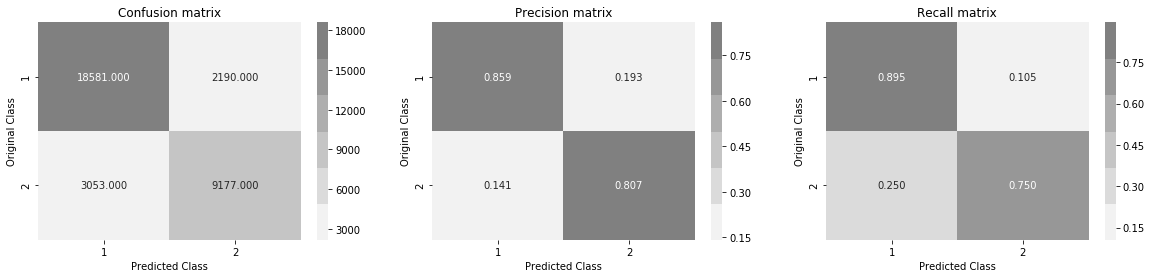

In [66]:
#### training model with best hyper parameter 

xgb_clf = xgb.XGBClassifier(subsample= 0.5, reg_alpha= 0.001, min_child_weight= 3,
                        max_depth= 10, learning_rate= 0.1, gamma= 0.1, eval_metric= 'logloss',
                        colsample_bytree= 0.5,random_state=42)
xgb_clf.fit(X_tr,y_train)
clf = CalibratedClassifierCV(xgb_clf,method='sigmoid',cv=5)
clf.fit(X_tr,y_train)
predict_y = clf.predict_proba(X_te)
predict_y_tr = clf.predict_proba(X_tr)
print('Model trained with best params ',rs_xgb.best_params_,'test log-loss is ',log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))
print('Model trained with best params ',rs_xgb.best_params_,'train log-loss is ',log_loss(y_train,predict_y_tr,labels=clf.classes_,eps=1e-15))
print("Total number of data points =", len(predicted_y))
predicted_y =np.argmax(predict_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h3> 4.5. Performance Comparison </h3>

In [72]:
##http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", " best Hyper Parameter", "Test - Loss"]

x.add_row(["Random Model",'' , 0.88])
x.add_row(["Logistic Regression",1e-05, 0.390])
x.add_row(["Linear SVM",0.0001,0.389])
x.add_row(["Xgboost",'''{'subsample': 0.9, 'reg_alpha': 0.01, 'min_child_weight': 5,'max_depth': 10,
         'learning_rate': 0.2, 'gamma': 0.1, 'eval_metric': 'logloss',
                        'colsample_bytree': 0.9}''', 0.34])
print(x)

+---------------------+------------------------------------------------------------------------------+-------------+
|        Model        |                             best Hyper Parameter                             | Test - Loss |
+---------------------+------------------------------------------------------------------------------+-------------+
|     Random Model    |                                                                              |     0.88    |
| Logistic Regression |                                    1e-05                                     |     0.39    |
|      Linear SVM     |                                    0.0001                                    |    0.389    |
|       Xgboost       | {'subsample': 0.9, 'reg_alpha': 0.01, 'min_child_weight': 5,'max_depth': 10, |     0.34    |
|                     |             'learning_rate': 0.2, 'gamma': 0.1, 'eval_metric': 'logloss',    |             |
|                     |                                       'c

In [77]:
print("We see that Xgboost performs better than other models with higher precision,recall and reduces loss considerably better than other models" )

We see that Xgboost performs better than other models with higher precision,recall and reduces loss considerably better than other models


## 5. Conclusion :
    

### 5.2  Step Wise Approach :
        


### 1. Business Problem

	1.1 Description
	1.2 Sources/Useful Links
	1.3 Real world/Business Objectives and Constraints 
    
### 2. Machine Learning Probelm

	2.1 Data
		2.1.1 Data Overview
		2.1.2 Example Data point
	2.2 Mapping the real world problem to an ML problem 
		2.2.1 Type of Machine Leaning Problem 	
		2.2.2 Performance Metric
	2.3 Train and Test Construction
    
### 3. EDA,Visualization,Storage and Vectorizations

	3.1 Reading data and basic stats 	
		3.2.1 Distribution of data points among output classes
	3.2 Basic Analyis 
		3.2.1 Distribution of data points among output classes
		3.2.2 Number of unique questions
		3.2.4 Check for duplicates
		3.2.5 Frequency of questions occuring in dataset
		3.2.6 Check for null values
	3.3 EDA : Generating basic features
		3.3.1 Univariate analysis on Basic features
			3.3.1.1 feature : Word Share	
			3.3.1.2 Feature: word_Common
	3.4 Preprocessing of Text		
	3.5 Advanced Feature Extraction (NLP and Fuzzy Features) 
		3.5.1 Adding a new advanced feature : similarity of nouns
		3.5.2 Analysis of extracted features
			3.5.2.1 Plotting Word clouds
			3.5.2.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio','noun_share']
	3.6 Visualization using TSNE in 2D and 3D
	3.7 Storing the data into SQL table
			3.7.1 Converting strings to numerics 
	3.8 Vectorizing using TFIDF on text data	
			3.8.1 Train,Test,Split
			3.8.2 Apply TFIDF vectorizer on text features
			3.8.3 Apply weighted TFIDF on text features
	3.9 Normalizing numerical features
    
### 4. MODEL BUILDING

	4.1 Building random model
	4.2 Logistic Regression with hyperparameter tuning
	4.3 Linear SVM with hyperparameter tuning
	4.4 XGBoost with hyperparameter tuning  
    4.5 Performance Comparisons